In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [3]:
emoid_ts = []
labels = [] # less than or greater than 15

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        age = int(meta[key]['meta']['AgeInMonths'])/12
        if age < 15:
            labels.append(0)
        else:
            labels.append(1)
        emoid_ts.append(meta[key]['emoidData'])
        
print(len(labels))
print(len(emoid_ts))

678
678


In [24]:
# Whole dataset

import numpy as np
import torch

emoid_ps = [np.corrcoef(ts) for ts in emoid_ts]
emoid_ps_t = torch.from_numpy(np.stack(emoid_ps)).float().cuda()

print(emoid_ps_t.shape)

torch.Size([678, 264, 264])


In [25]:
import networkx as nx

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('aij,bij->ab',ps1,ps2)
    F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

# Make split

graphs = []
idxSav = []
featSav = []
ASav = []
labelsSav = []

for nTrain in [600,600,678]:
    perm = torch.randperm(emoid_ps_t.shape[0])
    trainIdx = perm[:nTrain]

    emoid_ps_t_train = emoid_ps_t[trainIdx]
    labels_train = torch.tensor(labels)[trainIdx].long().cuda()

    print(emoid_ps_t_train.shape)
    print(labels_train.shape)

    # Make graph

    A = calcEdges(emoid_ps_t_train, emoid_ps_t_train)

    print('Done A')

    feat = emoid_ps_t_train.reshape(nTrain,264*264)

    print('Done feat')
    
    g = nx.Graph()
    
    for i in range(nTrain):
        g.add_node(i,feat=feat[i].detach().cpu().numpy(),
                   label=labels_train[i].detach().cpu().numpy())
        for j in range(i,nTrain):
            g.add_edge(i,j,weight=A[i,j].detach().cpu().numpy())
            
    graphs.append(g)
    idxSav.append(trainIdx)
    featSav.append(feat)
    ASav.append(A)
    labelsSav.append(labels_train)
    
    print(f'Finished {nTrain}')
    

torch.Size([600, 264, 264])
torch.Size([600])
Done A
Done feat
Finished 600
torch.Size([600, 264, 264])
torch.Size([600])
Done A
Done feat
Finished 600
torch.Size([678, 264, 264])
torch.Size([678])
Done A
Done feat
Finished 678


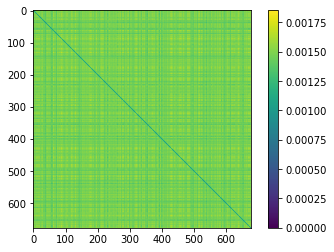

In [26]:
# Visualize

import matplotlib.pyplot as plt

plt.imshow(A.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [80]:
# Save graphs

data = [[graphs[0],graphs[1]],[1,1],[graphs[2],graphs[2]],[1,1]]

with open('../../Work/Explainer/GCN/1/EmoidGraphs1.pkl', 'wb') as f:
    pickle.dump(data, f)

In [67]:
# Validate GCN

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(264*264,100).float().cuda()
        self.gc2 = nn.Linear(100,2).float().cuda()
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x):
        A = x[0]+torch.eye(x[0].shape[0]).float().cuda()
        z = x[1]
        x = A@z
        x = F.relu(self.gc1(x))
        x = A@x
        x = F.sigmoid(self.gc2(x))
        return x
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=5e-6, weight_decay=0.2)

nEpoch = 15000
pPrint = 500

labelsLoss = torch.stack([labelsSav[1] == 0,labelsSav[1] == 1],dim=1).float().cuda()

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([ASav[1],featSav[1]]).squeeze()
    loss = gcn.loss(pred, labelsLoss)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')
        
print('Complete')

epoch 0 loss=0.6914345622062683
epoch 500 loss=0.5614515542984009
epoch 1000 loss=0.5300138592720032
epoch 1500 loss=0.5173133611679077
epoch 2000 loss=0.5120344161987305


KeyboardInterrupt: 

In [68]:
pred = gcn([ASav[2],featSav[2]]).squeeze()
print(pred[50:90])

tensor([[0.3780, 0.6205],
        [0.1731, 0.8254],
        [0.3439, 0.6523],
        [0.4936, 0.5014],
        [0.1472, 0.8514],
        [0.2020, 0.7976],
        [0.5019, 0.4998],
        [0.4802, 0.5215],
        [0.7025, 0.2992],
        [0.1078, 0.8913],
        [0.1090, 0.8899],
        [0.2773, 0.7220],
        [0.9224, 0.0777],
        [0.3254, 0.6719],
        [0.9523, 0.0481],
        [0.6983, 0.3027],
        [0.5518, 0.4462],
        [0.1015, 0.8973],
        [0.5925, 0.4052],
        [0.8379, 0.1630],
        [0.2030, 0.7955],
        [0.4787, 0.5198],
        [0.1664, 0.8326],
        [0.4981, 0.5035],
        [0.5003, 0.5023],
        [0.2045, 0.7930],
        [0.8372, 0.1645],
        [0.7324, 0.2658],
        [0.8302, 0.1706],
        [0.2712, 0.7287],
        [0.8468, 0.1532],
        [0.8860, 0.1145],
        [0.8008, 0.1995],
        [0.3679, 0.6286],
        [0.2174, 0.7806],
        [0.6300, 0.3707],
        [0.6960, 0.3052],
        [0.2140, 0.7826],
        [0.8

In [69]:
combined = torch.cat((idxSav[1],idxSav[2]))
uniques, counts = combined.unique(return_counts=True)
difference = uniques[counts == 1]
# intersection = uniques[counts > 1]
print(difference.shape)

torch.Size([78])


In [79]:
lab = (pred[difference][:,0] < pred[difference][:,1]).long()
print(lab)
print(torch.sum(labelsSav[2][difference] != lab))

tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0], device='cuda:0')
tensor(7, device='cuda:0')
